# Part 1

parse indeed jobs for multiple cities and job roles.

#### import required packages

In [26]:
#install packages
!pip install beautifulsoup4
!pip install fuzzywuzzy
!pip install pandas
!pip install requests
!pip install nltk
!pip install seaborn

# import packages
import requests
import bs4
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
import pandas as pd
import glob
import time
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import sys
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
nltk.download('wordnet') 

# hide warnings
import warnings
warnings.simplefilter('ignore')

sns.set(style='whitegrid',font_scale=1.5)

[nltk_data] Downloading package wordnet to /Users/tks/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### define variables

fetch around 300 jobs for each combination of job role and city.

In [2]:
# limit per sity
max_results_per_city = 300

# db of city Top ~50 North american cities
city_set = ['New+York','Los+Angeles','Chicago','Houston','Toronto','Washington','Atlanta','Boston','San+Francisco','Detroit','Montreal','Seattle','San+Diego','St+Louis','Vancouver','Portland','Cincinnati','Las+Vegas','Kansas+City','Columbus','Austin','San+Jose']

# job roles
job_set = ['business+analyst','data+scientist','data+engineer','data+mining+business+analyst','data+mining+analyst','business+intelligence+analyst','financial+analyst','risk+analyst','revenue+analyst','investment+analyst','credit/marketing+analyst','m&a+business+analyst','venture+&+research+analyst+intern','technical+analyst','marketing+data+analyst','operation+analyst','master+data+analyst','database+engineer','data+science+engineer','machine+learning+engineer','deep+learning+data+scientist','deep+learning+engineer','data+engineer','soft+ware+business+analyst','data+visualization+engineer','it+business+solution+analyst','big+data+engineer','big+data+manager','big+data+it+architect','big+data+architect']

#### Define functions

these are the set of fucntions that will parse data from HTML text extracted from the indeed website.

In [23]:
def extract_company(div): 
    try:
        company = div.find_all(name="span", attrs={"class":"company"})
        if len(company) > 0:
            for b in company:
                return (b.text.strip())
        else:
            sec_try = div.find_all(name="span", attrs={"class":"result-link-source"})
            for span in sec_try:
                return (span.text.strip())
    except:
        return 'NOT_FOUND'
    return 'NOT_FOUND'

def extract_salary(div): 
    try:
        return (div.find('nobr').text)
    except:
        try:
            div_two = div.find(name='div', attrs={'class':'sjcl'})
            div_three = div_two.find('div')
            salaries.append(div_three.text.strip())
        except:
            return ('NOT_FOUND')
    return 'NOT_FOUND'

def extract_location(div):
    try:
        for span in div.findAll('span', attrs={'class': 'location'}):
            return (span.text)
    except:
        return 'NOT_FOUND'
    return 'NOT_FOUND'

def extract_job_title(div):
    try:
        for a in div.find_all(name='a', attrs={'data-tn-element':'jobTitle'}):
            return (a['title'])
    except:
        return 'NOT_FOUND'
    return('NOT_FOUND')

def extract_summary(div): 
    try:
        spans = div.findAll('span', attrs={'class': 'summary'})
        for span in spans:
            return (span.text.strip())
    except:
        return 'NOT_FOUND'
    return 'NOT_FOUND'
 
def extract_link(div): 
    try:
        for a in div.find_all(name='a', attrs={'data-tn-element':'jobTitle'}):
            return (a['href'])
    except:
        return 'NOT_FOUND'
    return('NOT_FOUND')

def extract_date(div):
    try:
        spans = div.findAll('span', attrs={'class': 'date'})
        for span in spans:
            return (span.text.strip())
    except:
        return 'NOT_FOUND'
    return 'NOT_FOUND'

def extract_fulltext(url):
    try:
        page = requests.get('http://www.indeed.com' + url)
        soup = BeautifulSoup(page.text, "lxml", from_encoding="utf-8")
        spans = soup.findAll('span', attrs={'class': 'summary'})
        for span in spans:
            return (span.text.strip())
    except:
        return 'NOT_FOUND'
    return 'NOT_FOUND'

def extract_id(div):
    try:
        return div['id']
    except:
        return 'NOT_FOUND'
    return 'NOT_FOUND'

def write_logs(text):
    # print(text + '\n')
    f = open('log.txt','a')
    f.write(text + '\n')  
    f.close()

#### Test functions

try to parse data for a particular url

In [25]:
#fetch data
page = requests.get('http://www.indeed.com/jobs?q=data+scientist&l=toronto&start=0')
soup = BeautifulSoup(page.text, "lxml", from_encoding="utf-8")
divs = soup.find_all(name="div", attrs={"class":"row"})
test_jobs = []

for div in divs:  

    #job data after parsing
    job_post = [] 

    #append unique id 
    job_post.append(extract_id(div)) 

    #grabbing job title
    job_post.append(extract_job_title(div))

    #grabbing company
    job_post.append(extract_company(div))

    #grabbing location name
    job_post.append(extract_location(div))

    #grabbing summary text
    job_post.append(extract_summary(div)) 
    
    # append
    test_jobs.append(job_post)
    
#debug
test_jobs

[['NOT_FOUND', 'NOT_FOUND', 'NOT_FOUND', 'NOT_FOUND', 'NOT_FOUND'],
 ['pj_17b9512a1e2c2ddf',
  'Digital Insights - Data Scientist',
  'CGI',
  'Pittsburgh, PA',
  '\x95 Data Lake and Big Data Analytics Architecture. We are looking for an experienced Big Data Scientist with in-depth, hands-on knowledge of foundational data...'],
 ['pj_9cf23eb55e61aa2b',
  'Environmental Project Scientist',
  'Alliance Source Testing, LLC',
  'Pittsburgh, PA',
  'Alliance Source Testing (Alliance) is currently seeking to fill a Project Scientist position. Test data quality control....'],
 ['pj_601e875b03e34cf5',
  'Simulation Validation Engineer, Self-Driving',
  'Uber',
  'Pittsburgh, PA 15201',
  'You will collaborate with our data scientists, test operators, and autonomy developers to constantly improve the behavior of our simulation agents....'],
 ['p_a7517874638cd11d',
  'Data Scientist',
  'Lucas Systems, Inc.',
  'Wexford, PA 15090',
  'We are looking for Data Scientists that will help us discover

#### loop around and get data and save it file

file are saved as jobs_[file].csv

DISCLAIMER: This function took around 36 hrs on 4 cores to complete.

In [ ]:
# file num
file = 1
SKIPPER = 0

# loop on all cities
for city in city_set:
    
    # for each job role
    for job_qry in job_set:
        
        # count
        cnt = 0
        startTime = time.time()

        # skipper
        if(file > SKIPPER):
        
            # dataframe
            df = pd.DataFrame(columns = ['unique_id', 'city', 'job_qry','job_title', 'company_name', 'location', 'summary', 'salary', 'link', 'date', 'full_text'])
        
            # for results
            for start in range(0, max_results_per_city, 10):

                # get dom 
                page = requests.get('http://www.indeed.com/jobs?q=' + job_qry +'&l=' + str(city) + '&start=' + str(start))

                #ensuring at least 1 second between page grabs                    
                time.sleep(1)  

                #fetch data
                soup = BeautifulSoup(page.text, "lxml", from_encoding="utf-8")
                divs = soup.find_all(name="div", attrs={"class":"row"})
                
                # if results exist
                if(len(divs) == 0):
                    break

                # for all jobs on a page
                for div in divs: 

                    #specifying row num for index of job posting in dataframe
                    num = (len(df) + 1) 
                    cnt = cnt + 1

                    #job data after parsing
                    job_post = [] 

                    #append unique id 
                    job_post.append(extract_id(div))

                    #append city name
                    job_post.append(city)

                    #append job qry
                    job_post.append(job_qry)

                    #grabbing job title
                    job_post.append(extract_job_title(div))

                    #grabbing company
                    job_post.append(extract_company(div))

                    #grabbing location name
                    job_post.append(extract_location(div))

                    #grabbing summary text
                    job_post.append(extract_summary(div))

                    #grabbing salary
                    job_post.append(extract_salary(div))

                    #grabbing link
                    link = extract_link(div)
                    job_post.append(link)

                    #grabbing date
                    job_post.append(extract_date(div))

                    #grabbing full_text
                    job_post.append(extract_fulltext(link))

                    #appending list of job post info to dataframe at index num
                    df.loc[num] = job_post
                    
                #debug add
                write_logs(('Completed =>') + '\t' + city  + '\t' + job_qry + '\t' + str(cnt) + '\t' + str(start) + '\t' + str(time.time() - startTime) + '\t' + ('file_' + str(file)))

            #saving df as a local csv file 
            df.to_csv('jobs_' + str(file) + '.csv', encoding='utf-8')
        
        else:

            #debug add
            write_logs(('Skipped =>') + '\t' + city  + '\t' + job_qry + '\t' + str(-1) + '\t' + str(-1) + '\t' + str(time.time() - startTime) + '\t' + ('file_' + str(file)))
        
        # increment file
        file = file + 1

# Part 2

Read saved files and make dataframe

In [3]:
# natural sort for files
def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

# read all files
allFiles = natural_sort(glob.glob("*.csv"))

# read all files
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_, index_col=0)
    list_.append(df)

# create a single file
jobs = pd.concat(list_)

# debug
jobs.head()

,city,company_name,date,exp_yrs,freq,full_text,job_qry,job_title,link,location,...,superskill[Communication],superskill[Database],superskill[Leadership],superskill[Programming],superskill[Statistics],superskill[Teamwork],superskill[Visualization],type[hard],type[soft],unique_id
1,New+York,Avanade,1 hour ago,NaN,NaN,CRM Business Analysis\nMicrosoft has heightene...,business+analyst,365Dynamics CRM Business Analysis- Northeast r...,/pagead/clk?mo=r&ad=-6NYlbfkN0CDyWCk2bf-hB079X...,"New York, NY",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pj_14bd3754390fbca5
2,New+York,Innovest Systems LLC,1 hour ago,NaN,NaN,"Senior Business Analyst – BA TeamInnovest, a l...",business+analyst,Senior Business Analyst,/pagead/clk?mo=r&ad=-6NYlbfkN0DE0dyUnN-f_DUkr6...,"New York, NY 10014",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pj_f1fb3f1a21f9e120
3,New+York,RSG Media Systems LLC.,NOT_FOUND,NaN,NaN,"PRINCIPAL RESPONSIBILITIESResearch, design, an...",business+analyst,Business Analyst,/pagead/clk?mo=r&ad=-6NYlbfkN0Dv2XWb8kFnQcugWa...,"New York, NY",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pj_c8de3d196b4ed0d4
4,New+York,"Purolator International, Inc.",NOT_FOUND,NaN,NaN,"Who We AreWorking at Purolator International, ...",business+analyst,IT Business Analyst,/pagead/clk?mo=r&ad=-6NYlbfkN0BI6uDAUPIJ1XHjc9...,"Jericho, NY",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pj_c069cf64e5fbf351
5,New+York,Chenoa Information Services,12 hours ago,NaN,NaN,"To apply or know more details about this job, ...",business+analyst,Business Analyst,/rc/clk?jk=bb19aa8fa4fa262d&fccid=d9ea7f01646f...,"New York, NY 10004 (Financial District area)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,p_bb19aa8fa4fa262d


In [4]:
jobs.describe()

,exp_yrs,freq,skill[hard][ r ],skill[hard][ sql ],skill[hard][adversarial learning],skill[hard][algorithm],skill[hard][algorithmic],skill[hard][api],skill[hard][appengine],skill[hard][aws],...,superskill[Big Data],superskill[Communication],superskill[Database],superskill[Leadership],superskill[Programming],superskill[Statistics],superskill[Teamwork],superskill[Visualization],type[hard],type[soft]
count,374496.000000,362940.000000,11556.000000,11556.000000,11556.000000,11556.000000,11556.000000,11556.000000,11556.000000,11556.000000,...,11556.000000,11556.000000,11556.000000,11556.000000,11556.000000,11556.000000,11556.000000,11556.000000,11556.000000,11556.000000
mean,4.270457,0.736130,0.113015,0.291277,0.000087,0.088525,0.007442,0.225597,0.000346,0.151956,...,0.350813,2.184147,0.352890,0.496192,0.931464,0.479232,0.346746,0.082728,3.801575,3.904984
std,3.064044,4.612514,0.316625,0.454371,0.009302,0.284070,0.085949,0.417993,0.018602,0.358993,...,0.681447,1.540233,0.551691,0.738086,1.163996,0.868209,0.538568,0.283837,3.727615,2.336653
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
50%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,4.000000
75%,7.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,5.000000,5.000000
max,10.000000,381.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,3.000000,8.000000,3.000000,5.000000,7.000000,6.000000,2.000000,3.000000,26.000000,13.000000


#### Remove duplicates jobs based on id

In [5]:
jobs = jobs.drop_duplicates(subset=['unique_id'], keep='first') 
jobs.describe()

,exp_yrs,freq,skill[hard][ r ],skill[hard][ sql ],skill[hard][adversarial learning],skill[hard][algorithm],skill[hard][algorithmic],skill[hard][api],skill[hard][appengine],skill[hard][aws],...,superskill[Big Data],superskill[Communication],superskill[Database],superskill[Leadership],superskill[Programming],superskill[Statistics],superskill[Teamwork],superskill[Visualization],type[hard],type[soft]
count,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,7.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,6.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,7.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,6.0
25%,7.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,6.0
50%,7.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,6.0
75%,7.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,6.0
max,7.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,6.0


#### Remove jobs roles that are not required

@todo check this function

In [6]:
def check_validity(qry, title):
    fz = fuzz.ratio(qry.lower(), title.lower())
    return (1 if fz > 50 else 0) 

# remove jobs that are too off from job title
jobs['isValid'] = jobs.apply(lambda x: check_validity(x['job_qry'], x['job_title']),axis=1)
jobs = jobs[jobs['isValid'] == 1]

# remove unwanted columns
jobs = jobs.drop(['isValid', 'link'], axis=1)

In [7]:
# describe
jobs.describe()

,exp_yrs,freq,skill[hard][ r ],skill[hard][ sql ],skill[hard][adversarial learning],skill[hard][algorithm],skill[hard][algorithmic],skill[hard][api],skill[hard][appengine],skill[hard][aws],...,superskill[Big Data],superskill[Communication],superskill[Database],superskill[Leadership],superskill[Programming],superskill[Statistics],superskill[Teamwork],superskill[Visualization],type[hard],type[soft]
count,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,7.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,6.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,7.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,6.0
25%,7.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,6.0
50%,7.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,6.0
75%,7.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,6.0
max,7.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,6.0


In [8]:
# get top rows
jobs.head()

,city,company_name,date,exp_yrs,freq,full_text,job_qry,job_title,location,programType,...,superskill[Communication],superskill[Database],superskill[Leadership],superskill[Programming],superskill[Statistics],superskill[Teamwork],superskill[Visualization],type[hard],type[soft],unique_id
2,New+York,Innovest Systems LLC,1 hour ago,NaN,NaN,"Senior Business Analyst – BA TeamInnovest, a l...",business+analyst,Senior Business Analyst,"New York, NY 10014",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pj_f1fb3f1a21f9e120
3,New+York,RSG Media Systems LLC.,NOT_FOUND,NaN,NaN,"PRINCIPAL RESPONSIBILITIESResearch, design, an...",business+analyst,Business Analyst,"New York, NY",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pj_c8de3d196b4ed0d4
4,New+York,"Purolator International, Inc.",NOT_FOUND,NaN,NaN,"Who We AreWorking at Purolator International, ...",business+analyst,IT Business Analyst,"Jericho, NY",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pj_c069cf64e5fbf351
5,New+York,Chenoa Information Services,12 hours ago,NaN,NaN,"To apply or know more details about this job, ...",business+analyst,Business Analyst,"New York, NY 10004 (Financial District area)",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,p_bb19aa8fa4fa262d
6,New+York,computing concepts inc.,7 days ago,NaN,NaN,Key Responsibilities:Provide administrative su...,business+analyst,Business Analyst,"New York, NY 10036",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,p_b9902514e954ec60


#### plot showing unique jobs for each job role query.

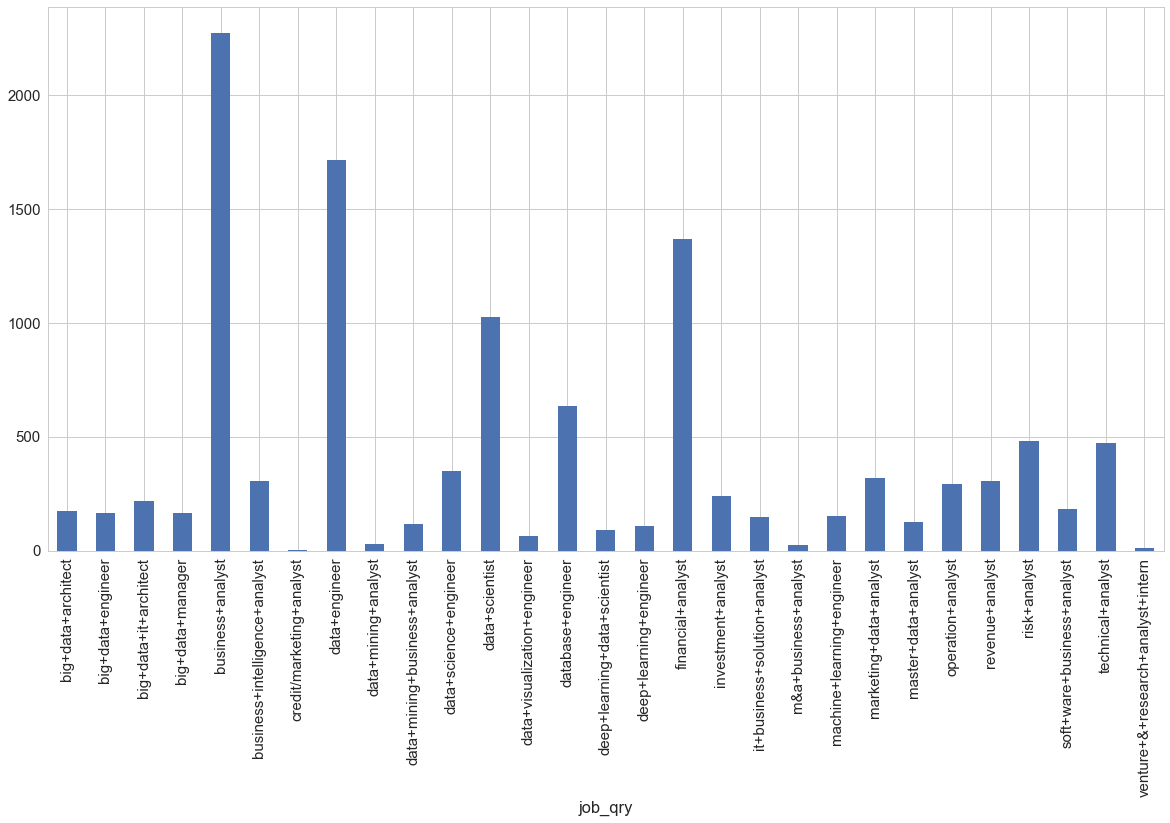

In [9]:
fig, axis1 = plt.subplots(1,1,figsize=(20,10))
jobs.groupby('job_qry').size().plot(kind='bar')  

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

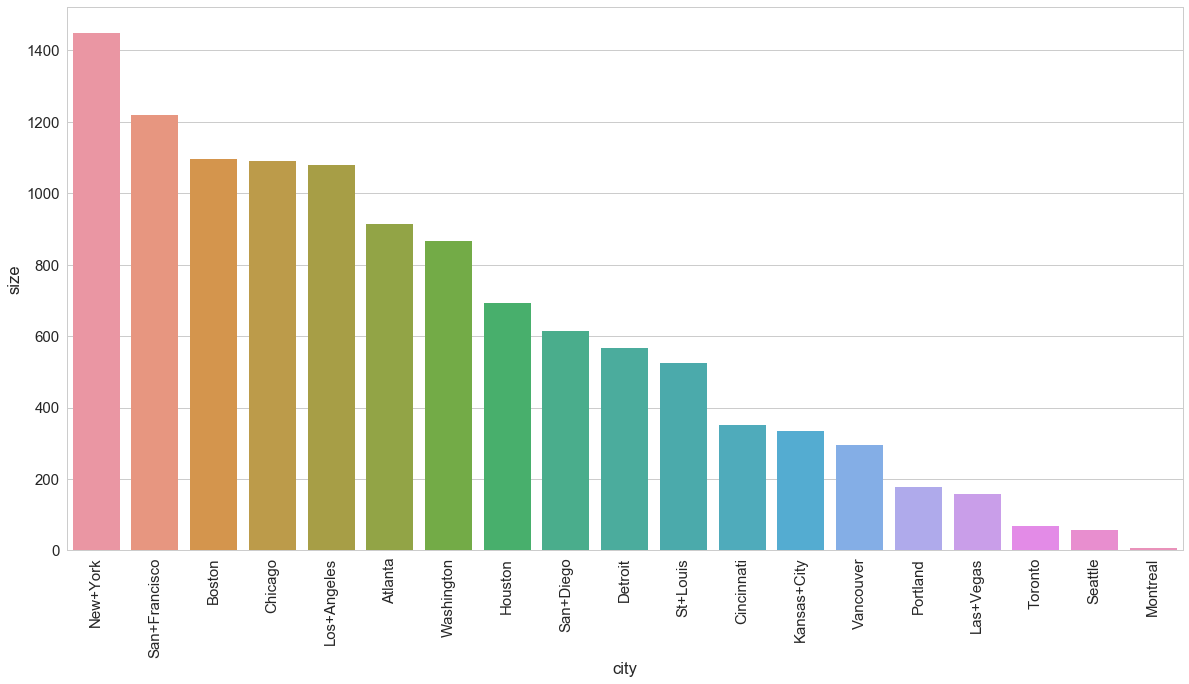

In [25]:
fig, axis1 = plt.subplots(1,1,figsize=(20,10))
a = jobs.groupby('city').size().to_frame('size').sort_values(by=['size'], ascending=False).reset_index()
sns.barplot(x="city", y="size", data=a) 
plt.xticks(rotation=90)

#### pretty bad job scenario in canada ;(

save results in a file

In [16]:
# save file
jobs.to_csv('jobsFinalNew.csv')

# Part 3

parse skills

In [27]:
# read file
jd = pd.read_csv('jobsFinalNew.csv', index_col=0)

#debug
jd.head()

,city,company_name,date,full_text,job_qry,job_title,location,salary,summary,unique_id
2,New+York,Innovest Systems LLC,1 hour ago,"Senior Business Analyst – BA TeamInnovest, a l...",business+analyst,Senior Business Analyst,"New York, NY 10014",NOT_FOUND,Strong Business Analyst skills. Senior Busines...,pj_f1fb3f1a21f9e120
3,New+York,RSG Media Systems LLC.,NOT_FOUND,"PRINCIPAL RESPONSIBILITIESResearch, design, an...",business+analyst,Business Analyst,"New York, NY",NOT_FOUND,Strong business software application knowledge...,pj_c8de3d196b4ed0d4
4,New+York,"Purolator International, Inc.",NOT_FOUND,"Who We AreWorking at Purolator International, ...",business+analyst,IT Business Analyst,"Jericho, NY",NOT_FOUND,IT Business Analyst or Business Specialist:. P...,pj_c069cf64e5fbf351
5,New+York,Chenoa Information Services,12 hours ago,"To apply or know more details about this job, ...",business+analyst,Business Analyst,"New York, NY 10004 (Financial District area)",NOT_FOUND,Must have experience as a business analyst in ...,p_bb19aa8fa4fa262d
6,New+York,computing concepts inc.,7 days ago,Key Responsibilities:Provide administrative su...,business+analyst,Business Analyst,"New York, NY 10036",NOT_FOUND,Update Harvard Business Review landing page wi...,p_b9902514e954ec60


In [28]:
#### add isBusinnes filter for different programs.

In [29]:
# add job type
def isBusiness(job_title):
    ll = ['manager', 'business']
    job_title = job_title.lower()
    for l in ll:
        if job_title.find(l) > -1:
            return 'business'
    return 'engineering'

# add isBusiness flag
jd['programType'] = jd['job_title'].apply(isBusiness)

#debug
jd.head()

,city,company_name,date,full_text,job_qry,job_title,location,salary,summary,unique_id,programType
2,New+York,Innovest Systems LLC,1 hour ago,"Senior Business Analyst – BA TeamInnovest, a l...",business+analyst,Senior Business Analyst,"New York, NY 10014",NOT_FOUND,Strong Business Analyst skills. Senior Busines...,pj_f1fb3f1a21f9e120,business
3,New+York,RSG Media Systems LLC.,NOT_FOUND,"PRINCIPAL RESPONSIBILITIESResearch, design, an...",business+analyst,Business Analyst,"New York, NY",NOT_FOUND,Strong business software application knowledge...,pj_c8de3d196b4ed0d4,business
4,New+York,"Purolator International, Inc.",NOT_FOUND,"Who We AreWorking at Purolator International, ...",business+analyst,IT Business Analyst,"Jericho, NY",NOT_FOUND,IT Business Analyst or Business Specialist:. P...,pj_c069cf64e5fbf351,business
5,New+York,Chenoa Information Services,12 hours ago,"To apply or know more details about this job, ...",business+analyst,Business Analyst,"New York, NY 10004 (Financial District area)",NOT_FOUND,Must have experience as a business analyst in ...,p_bb19aa8fa4fa262d,business
6,New+York,computing concepts inc.,7 days ago,Key Responsibilities:Provide administrative su...,business+analyst,Business Analyst,"New York, NY 10036",NOT_FOUND,Update Harvard Business Review landing page wi...,p_b9902514e954ec60,business


Text(0,0.5,'Number of Jobs')

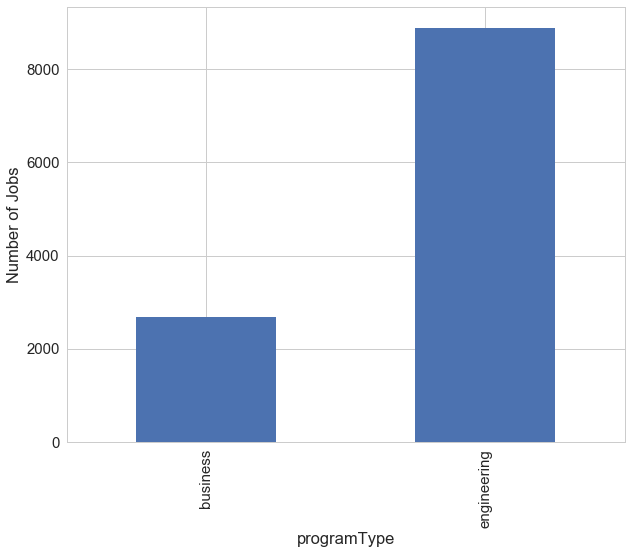

In [30]:
fig, axis1 = plt.subplots(1,1,figsize=(10,8))
ax = jd.groupby('programType').size().plot(kind='bar')  
ax.set_ylabel("Number of Jobs")

#### Add years of experience column

In [31]:
# data experience
def get_experience(text):
    
    # retun arr
    arr = []
    
    # Get pos index of year keyword
    posArr = [m.start() for m in re.finditer('year', text)]
    
    # for each pos match
    for posIndex in posArr:
        
        # get start and end of string to be extracted
        sNum = posIndex - 25
        eNum = posIndex + 25
        
        # get number
        numArr = [m.group() for m in re.finditer('([0-9]+)', text[sNum:eNum])]
        
        # remove shitty numbers
        for idx, n in enumerate(numArr):
            if(int(n) > 10):
                numArr[idx] = 0
            else:
                numArr[idx] = int(n)
        
        #push max num to arr
        arr.append(0 if len(numArr) == 0 else (max(numArr)))
    
    # return
    return 0 if len(arr) == 0 else max(arr)

# get_experience raw_text
jd['exp_yrs'] = jd['full_text'].apply(get_experience)

Text(0.5,0,'Years of Experience')

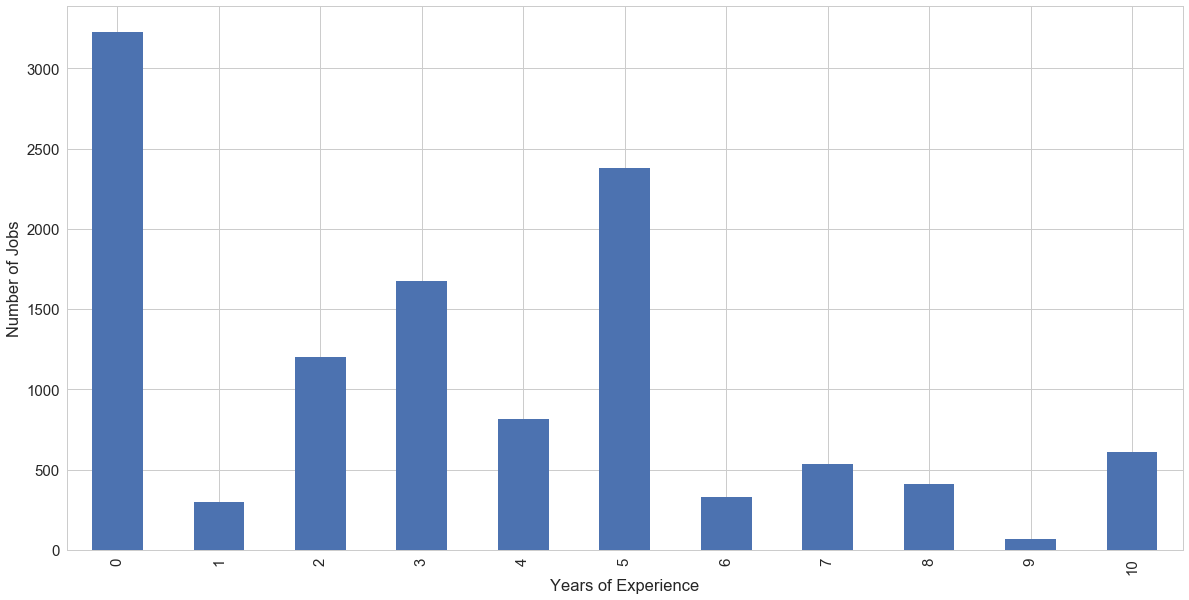

In [32]:
fig, axis1 = plt.subplots(1,1,figsize=(20,10))
ax = jd.groupby('exp_yrs').size().plot(kind='bar')  
ax.set_ylabel("Number of Jobs")
ax.set_xlabel("Years of Experience")

Text(0.5,0,'Years of Experience')

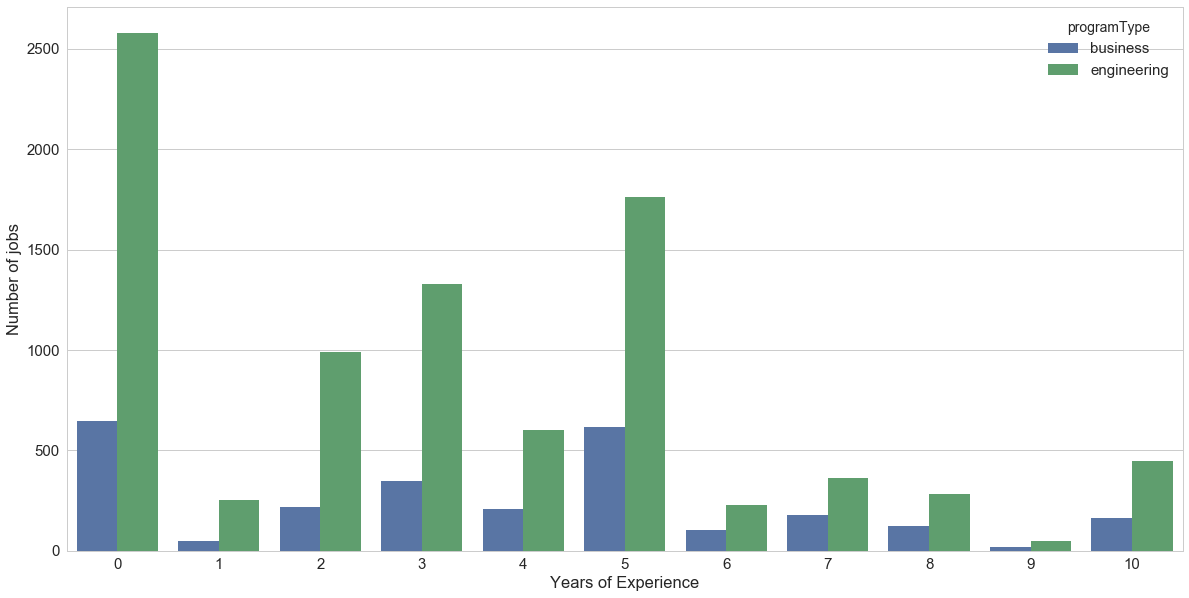

In [33]:
fig, axis1 = plt.subplots(1,1,figsize=(20,10))
ax = sns.barplot(y="count", x="exp_yrs", hue="programType", data=jd.groupby(['exp_yrs', 'programType']).size().to_frame('count').reset_index())
ax.set_ylabel("Number of jobs")
ax.set_xlabel("Years of Experience")

#### cleanup raw text before parsing skills

In [34]:
STOPWORDS = set(stopwords.words('english'))

def cleanup_text(text):
    
    # tokenize
    tokens = word_tokenize(text)
    
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    
    # remove all tokens that are not alphabetic
    words = [word for word in tokens if word.isalpha()]

    # remove stop words
    words = [w for w in words if not w in STOPWORDS]
    
    # return
    return " ".join(words)

# cleanup raw_text
jd['clean_text'] = jd['full_text'].apply(cleanup_text)  

# debug
jd.describe()

,exp_yrs
count,11556.000000
mean,3.342593
std,2.859840
min,0.000000
25%,0.000000
50%,3.000000
75%,5.000000
max,10.000000


In [35]:
# drop columns
jd = jd.drop(['summary', 'unique_id', 'salary', 'full_text', 'company_name'], axis=1)

#debug 
jd.head() 

,city,date,job_qry,job_title,location,programType,exp_yrs,clean_text
2,New+York,1 hour ago,business+analyst,Senior Business Analyst,"New York, NY 10014",business,7,senior business analyst ba teaminnovest leadin...
3,New+York,NOT_FOUND,business+analyst,Business Analyst,"New York, NY",business,5,principal responsibilitiesresearch design docu...
4,New+York,NOT_FOUND,business+analyst,IT Business Analyst,"Jericho, NY",business,3,areworking purolator international job opportu...
5,New+York,12 hours ago,business+analyst,Business Analyst,"New York, NY 10004 (Financial District area)",business,5,apply know details job please feel free call u...
6,New+York,7 days ago,business+analyst,Business Analyst,"New York, NY 10036",business,4,key responsibilities provide administrative su...


#### define skills keywork list

In [36]:
skills = [{"Skill":" r ","Type":"hard","Superskill":"Programming"},
{"Skill":"adversarial learning","Type":"hard","Superskill":"Algorithms"},
{"Skill":"algorithm","Type":"hard","Superskill":"Algorithms"},
{"Skill":"algorithmic","Type":"hard","Superskill":"Algorithms"},
{"Skill":"analytic","Type":"soft","Superskill":"Analytical"},
{"Skill":"tools","Type":"hard","Superskill":"Analysis Tools"},
{"Skill":"api","Type":"hard","Superskill":"Programming"},
{"Skill":"appengine","Type":"hard","Superskill":"Big Data"},
{"Skill":"assertiveness","Type":"soft","Superskill":"Analytical"},
{"Skill":"aws","Type":"hard","Superskill":"Big Data"},
{"Skill":"bayesian","Type":"hard","Superskill":"Algorithms"},
{"Skill":"big data","Type":"hard","Superskill":"Big Data"},
{"Skill":"c++","Type":"hard","Superskill":"Programming"},
{"Skill":"caret","Type":"hard","Superskill":"Programming"},
{"Skill":"cnns ","Type":"hard","Superskill":"Algorithms"},
{"Skill":"collaboration","Type":"soft","Superskill":"Teamwork"},
{"Skill":"communication","Type":"soft","Superskill":"Communication"},
{"Skill":"computer skills","Type":"hard","Superskill":"Programming"},
{"Skill":"computer vision","Type":"hard","Superskill":"Algorithms"},
{"Skill":"consulting","Type":"soft","Superskill":"Communication"},
{"Skill":"couchdb","Type":"hard","Superskill":"Programming"},
{"Skill":"creating algorithms","Type":"hard","Superskill":"Algorithms"},
{"Skill":"creativity","Type":"soft","Superskill":"Analytical"},
{"Skill":"critical thinking","Type":"soft","Superskill":"Communication"},
{"Skill":"customer service","Type":"soft","Superskill":"Communication"},
{"Skill":"d3","Type":"hard","Superskill":"Visualization"},
{"Skill":"data analysis","Type":"hard","Superskill":"Statistics"},
{"Skill":"data analytics","Type":"hard","Superskill":"Statistics"},
{"Skill":"data manipulation","Type":"hard","Superskill":"Database"},
{"Skill":"data mining","Type":"hard","Superskill":"Algorithms"},
{"Skill":"data science tool","Type":"hard","Superskill":"Analysis Tools"},
{"Skill":"data tools","Type":"hard","Superskill":"Analysis Tools"},
{"Skill":"data wrangling","Type":"hard","Superskill":"Programming"},
{"Skill":"decision making","Type":"soft","Superskill":"Communication"},
{"Skill":"decision trees","Type":"hard","Superskill":"Algorithms"},
{"Skill":"documenting","Type":"soft","Superskill":"Communication"},
{"Skill":"dplyr","Type":"hard","Superskill":"Big Data"},
{"Skill":"drawing consensus","Type":"soft","Superskill":"Analytical"},
{"Skill":"ecl","Type":"hard","Superskill":"Programming"},
{"Skill":"ensemble methods","Type":"hard","Superskill":"Algorithms"},
{"Skill":"facilitating meetings","Type":"soft","Superskill":"Leadership"},
{"Skill":"flare","Type":"hard","Superskill":"Analysis Tools"},
{"Skill":"fraud detection","Type":"hard","Superskill":"Algorithms"},
{"Skill":"gans","Type":"hard","Superskill":"Algorithms"},
{"Skill":"ggplot2","Type":"hard","Superskill":"Visualization"},
{"Skill":"gradient boosted machines","Type":"hard","Superskill":"Algorithms"},
{"Skill":"guidance","Type":"soft","Superskill":"Leadership"},
{"Skill":"hadoop","Type":"hard","Superskill":"Big Data"},
{"Skill":"hbase","Type":"hard","Superskill":"Programming"},
{"Skill":"hmms","Type":"hard","Superskill":"Algorithms"},
{"Skill":"information retrieval","Type":"hard","Superskill":"Statistics"},
{"Skill":"interpreting data","Type":"soft","Superskill":"Analytical"},
{"Skill":"java","Type":"hard","Superskill":"Programming"},
{"Skill":"keras","Type":"hard","Superskill":"Programming"},
{"Skill":"leadership","Type":"soft","Superskill":"Leadership"},
{"Skill":"linear algebra","Type":"hard","Superskill":"Statistics"},
{"Skill":"logical thinking","Type":"soft","Superskill":"Analytical"},
{"Skill":"machine learning","Type":"hard","Superskill":"Algorithms"},
{"Skill":"machine learning model","Type":"hard","Superskill":"Algorithms"},
{"Skill":"machine learning technique","Type":"hard","Superskill":"Algorithms"},
{"Skill":"machine translation","Type":"hard","Superskill":"Algorithms"},
{"Skill":"markov logic","Type":"hard","Superskill":"Algorithms"},
{"Skill":"mathematics","Type":"hard","Superskill":"Statistics"},
{"Skill":"matlab","Type":"hard","Superskill":"Programming"},
{"Skill":"matplotlib","Type":"hard","Superskill":"Visualization"},
{"Skill":"watson","Type":"hard","Superskill":"Visualization"},
{"Skill":"mentoring","Type":"soft","Superskill":"Leadership"},
{"Skill":"metrics","Type":"hard","Superskill":"Analytical"},
{"Skill":"microsoft excel","Type":"hard","Superskill":"Programming"},
{"Skill":"modeling","Type":"hard","Superskill":"Analytical"},
{"Skill":"multivariable calculus","Type":"soft","Superskill":"Statistics"},
{"Skill":"natural language processing","Type":"hard","Superskill":"Algorithms"},
{"Skill":"networks","Type":"hard","Superskill":"Algorithms"},
{"Skill":"neural networks","Type":"hard","Superskill":"Algorithms"},
{"Skill":"nltk","Type":"hard","Superskill":"Algorithms"},
{"Skill":"nosql","Type":"hard","Superskill":"Database"},
{"Skill":"numpy","Type":"hard","Superskill":"Statistics"},
{"Skill":"opencv","Type":"hard","Superskill":"Algorithms"},
{"Skill":"optimization","Type":"hard","Superskill":"Algorithms"},
{"Skill":"pandas","Type":"hard","Superskill":"Programming"},
{"Skill":"perl","Type":"hard","Superskill":"Programming"},
{"Skill":"powerpoint","Type":"hard","Superskill":"Communication"},
{"Skill":"predictive models","Type":"hard","Superskill":"Algorithms"},
{"Skill":"presentation","Type":"soft","Superskill":"Communication"},
{"Skill":"problem solving","Type":"soft","Superskill":"Analytical"},
{"Skill":"project management","Type":"soft","Superskill":"Leadership"},
{"Skill":"project management methodologies","Type":"soft","Superskill":"Leadership"},
{"Skill":"project timelines","Type":"soft","Superskill":"Teamwork"},
{"Skill":"python","Type":"hard","Superskill":"Programming"},
{"Skill":"random forests","Type":"hard","Superskill":"Algorithms"},
{"Skill":"recommendation engines","Type":"hard","Superskill":"Algorithms"},
{"Skill":"reinforcement learning","Type":"hard","Superskill":"Algorithms"},
{"Skill":"report","Type":"soft","Superskill":"Communication"},
{"Skill":"research","Type":"soft","Superskill":"Analytical"},
{"Skill":"risk modeling","Type":"hard","Superskill":"Programming"},
{"Skill":"rnns ","Type":"hard","Superskill":"Algorithms"},
{"Skill":"sas","Type":"hard","Superskill":"Analysis Tools"},
{"Skill":"scikit","Type":"hard","Superskill":"Statistics"}, 
{"Skill":"scipy","Type":"hard","Superskill":"Programming"},
{"Skill":"scripting languages","Type":"hard","Superskill":"Programming"},
{"Skill":"seaborn","Type":"hard","Superskill":"Visualization"},
{"Skill":"sklearn","Type":"hard","Superskill":"Programming"},
{"Skill":"social media","Type":"hard","Superskill":"Statistics"},
{"Skill":"speech recognition","Type":"hard","Superskill":"Algorithms"},
{"Skill":" sql ","Type":"hard","Superskill":"Database"},
{"Skill":"statistical learning models","Type":"hard","Superskill":"Statistics"},
{"Skill":"statistical modeling","Type":"hard","Superskill":"Statistics"},
{"Skill":"statistics","Type":"hard","Superskill":"Statistics"},
{"Skill":"supervised","Type":"hard","Superskill":"Algorithms"},
{"Skill":"simulation","Type":"hard","Superskill":"Statistics"},
{"Skill":"supervisory","Type":"soft","Superskill":"Leadership"},
{"Skill":"survival analysis","Type":"hard","Superskill":"Algorithms"},
{"Skill":"svms ","Type":"hard","Superskill":"Algorithms"},
{"Skill":"tableau","Type":"hard","Superskill":"Visualization"},
{"Skill":"sisense","Type":"hard","Superskill":"Visualization"},
{"Skill":"power bi","Type":"hard","Superskill":"Visualization"},
{"Skill":"tensorflow","Type":"hard","Superskill":"Algorithms"},
{"Skill":"testing hypotheses","Type":"hard","Superskill":"Statistics"},
{"Skill":"theano","Type":"hard","Superskill":"Programming"},
{"Skill":"time series ","Type":"hard","Superskill":"Algorithms"},
{"Skill":"training","Type":"soft","Superskill":"Teamwork"},
{"Skill":"unsupervised","Type":"hard","Superskill":"Algorithms"},
{"Skill":"verbal","Type":"soft","Superskill":"Communication"},
{"Skill":"visualization","Type":"hard","Superskill":"Analysis Tools"},
{"Skill":"working independently","Type":"soft","Superskill":"Leadership"},
{"Skill":"writing","Type":"soft","Superskill":"Communication"},
{"Skill":"xgboost","Type":"hard","Superskill":"Algorithms"}]
 

#### search skills in cleaned text

In [37]:
# Add columns req
for s in skills:
    jd[('skill[' + s['Type'] + '][' + s['Skill']) +']'] = 0
    jd[('type[' + s['Type']) +']'] = 0
    jd[('superskill[' + s['Superskill'] +']')] = 0
    
# search skills in full text
def search_skill(txt, skill):
    return 1 if txt.find(skill) > 0 else 0

# loop
for s in skills: 
     
    # for skills
    jd[('skill[' + s['Type'] + '][' + s['Skill']) +']'] = jd.apply(lambda row: (search_skill(row['clean_text'], s['Skill'])), axis=1)
    
    # for hard/soft
    jd[('type[' + s['Type'] +']')] = jd[('type[' + s['Type'] +']')] + jd[('skill[' + s['Type'] + '][' + s['Skill']) +']']
    
    # for super skill
    jd[('superskill[' + s['Superskill'] +']')] = jd[('superskill[' + s['Superskill'] +']')] + jd[('skill[' + s['Type'] + '][' + s['Skill']) +']']
   
    

In [38]:
jd.describe()

,exp_yrs,skill[hard][ r ],type[hard],superskill[Programming],skill[hard][adversarial learning],superskill[Algorithms],skill[hard][algorithm],skill[hard][algorithmic],skill[soft][analytic],type[soft],...,skill[hard][testing hypotheses],skill[hard][theano],skill[hard][time series ],skill[soft][training],skill[hard][unsupervised],skill[soft][verbal],skill[hard][visualization],skill[soft][working independently],skill[soft][writing],skill[hard][xgboost]
count,11556.000000,11556.000000,11556.000000,11556.000000,11556.000000,11556.000000,11556.000000,11556.000000,11556.000000,11556.000000,...,11556.000000,11556.000000,11556.0,11556.000000,11556.000000,11556.000000,11556.000000,11556.000000,11556.000000,11556.000000
mean,3.342593,0.113015,3.816199,0.931464,0.000087,0.535393,0.088525,0.007442,0.522153,3.904984,...,0.001298,0.003721,0.0,0.238664,0.007961,0.264798,0.089391,0.010038,0.157061,0.000779
std,2.859840,0.316625,3.740381,1.163996,0.009302,1.222412,0.284070,0.085949,0.499531,2.336653,...,0.036006,0.060889,0.0,0.426285,0.088874,0.441244,0.285319,0.099690,0.363874,0.027898
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,0.000000,5.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,5.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,10.000000,1.000000,26.000000,7.000000,1.000000,12.000000,1.000000,1.000000,1.000000,13.000000,...,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5,0,'skill type')

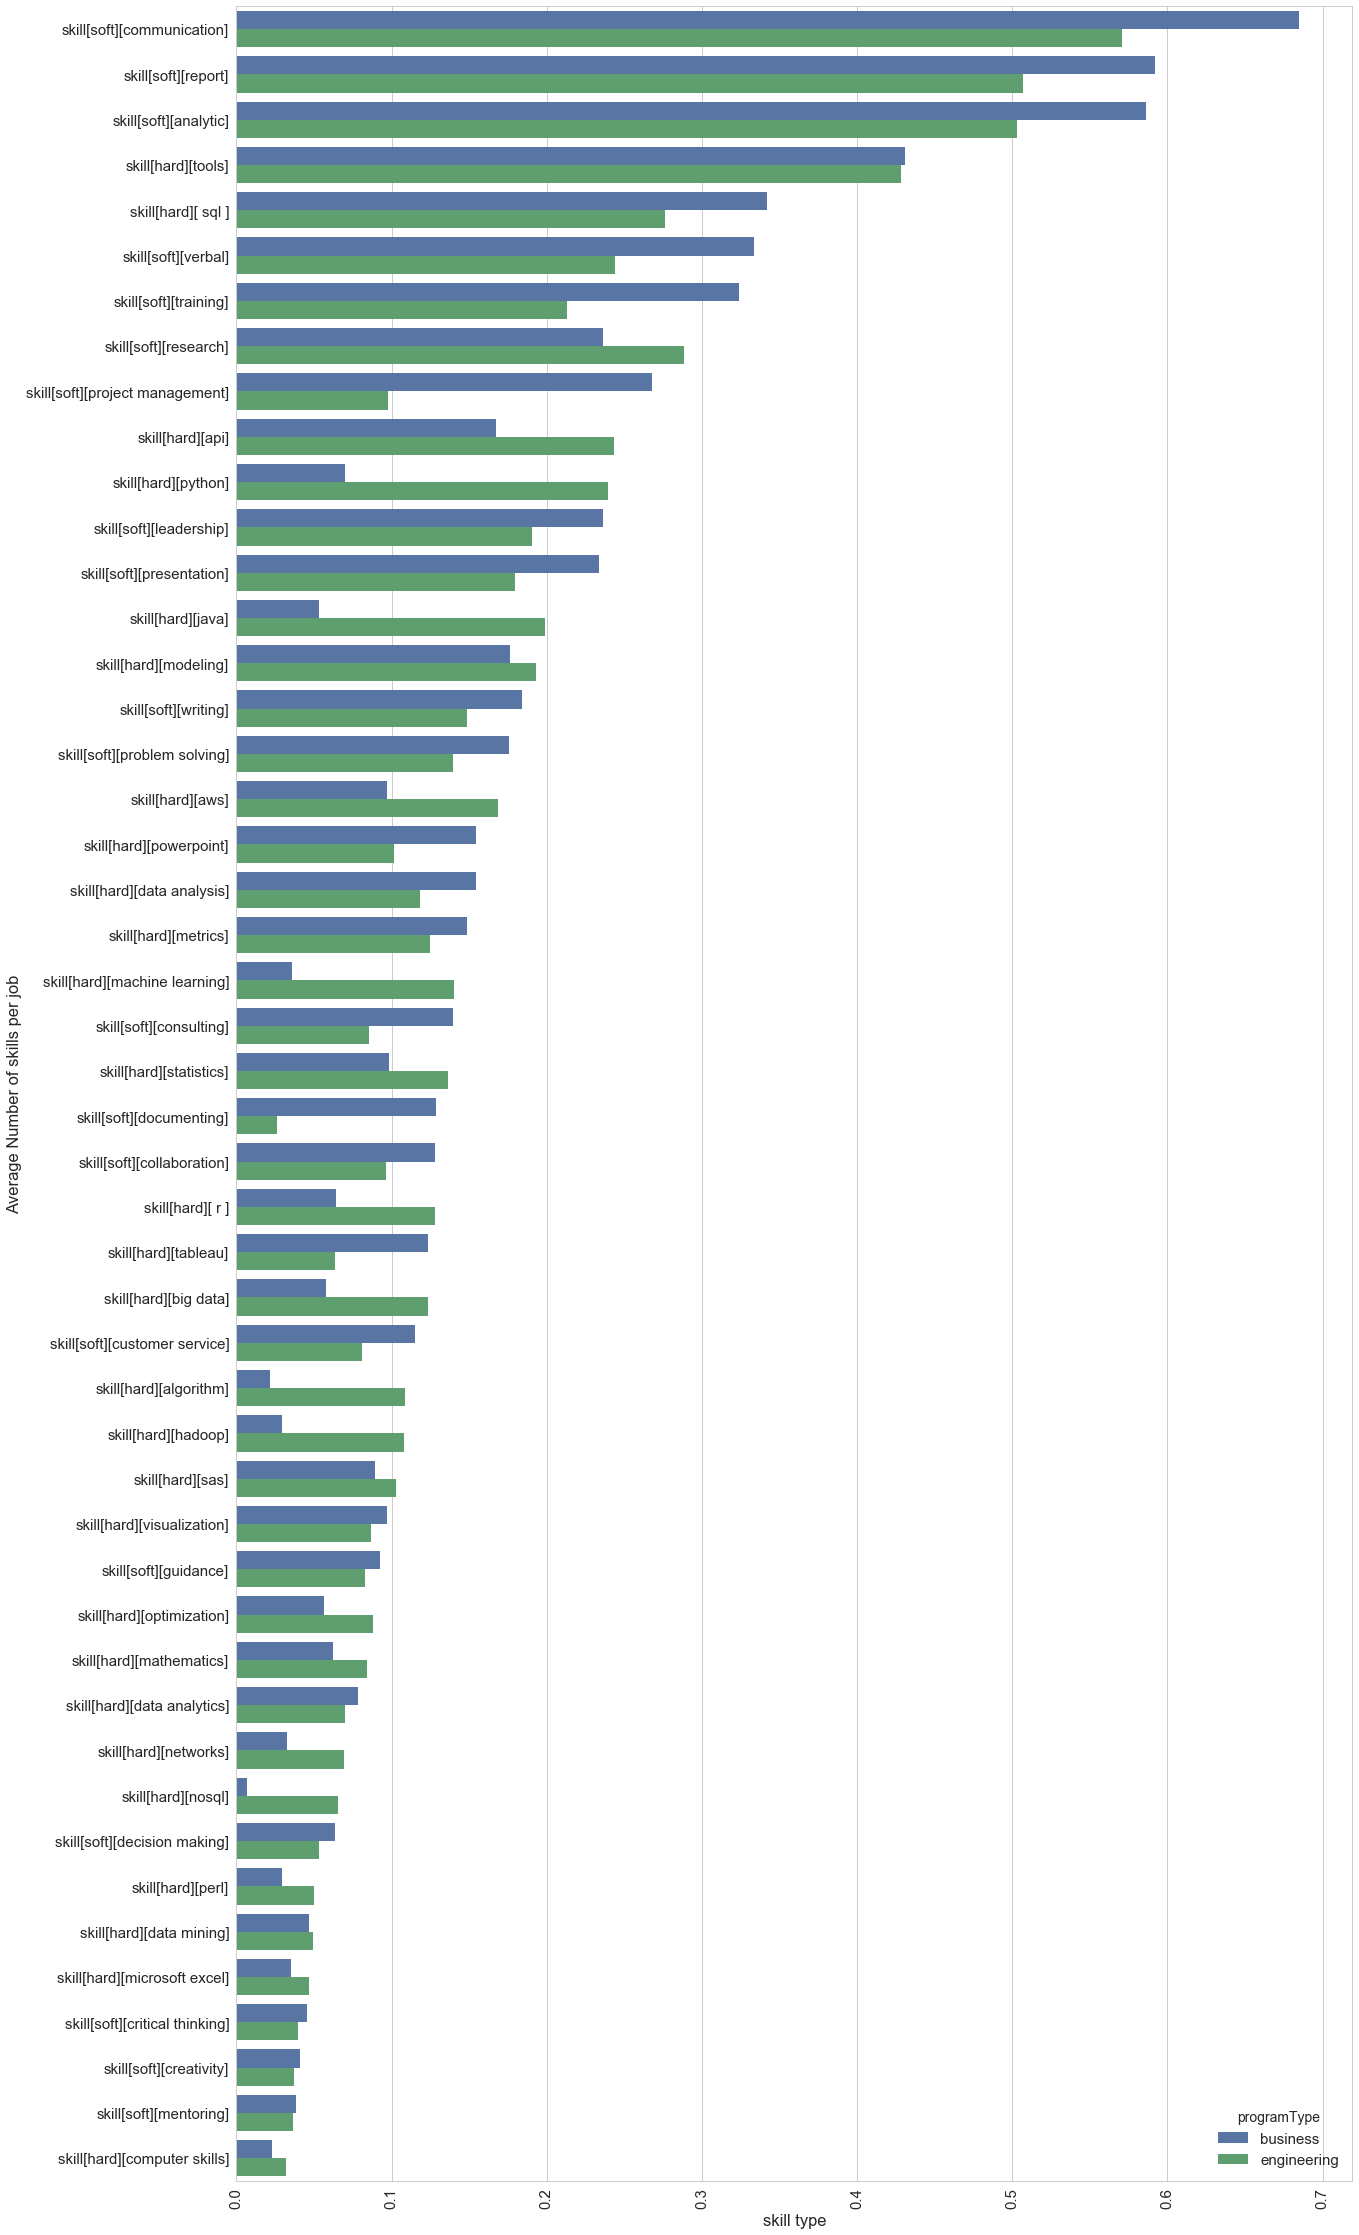

In [56]:
#plot freq
jdS = jd.filter(regex=("^skill.*"))
jdS['programType'] = jd['programType']
data = jdS.groupby('programType').mean()
data = data[data.columns[data.sum() > .05]]
a = data.reset_index().melt(id_vars=['programType']) 
a = a.sort_values(by=['value', 'variable'], ascending=[False,False])
fig, axis1 = plt.subplots(1,1,figsize=(20,40))
ax = sns.barplot(y="variable", x="value", hue="programType", data=a) 
plt.xticks(rotation=90)
ax.set_ylabel("Average Number of skills per job")
ax.set_xlabel("skill type")

Text(0.5,0,'super skill type')

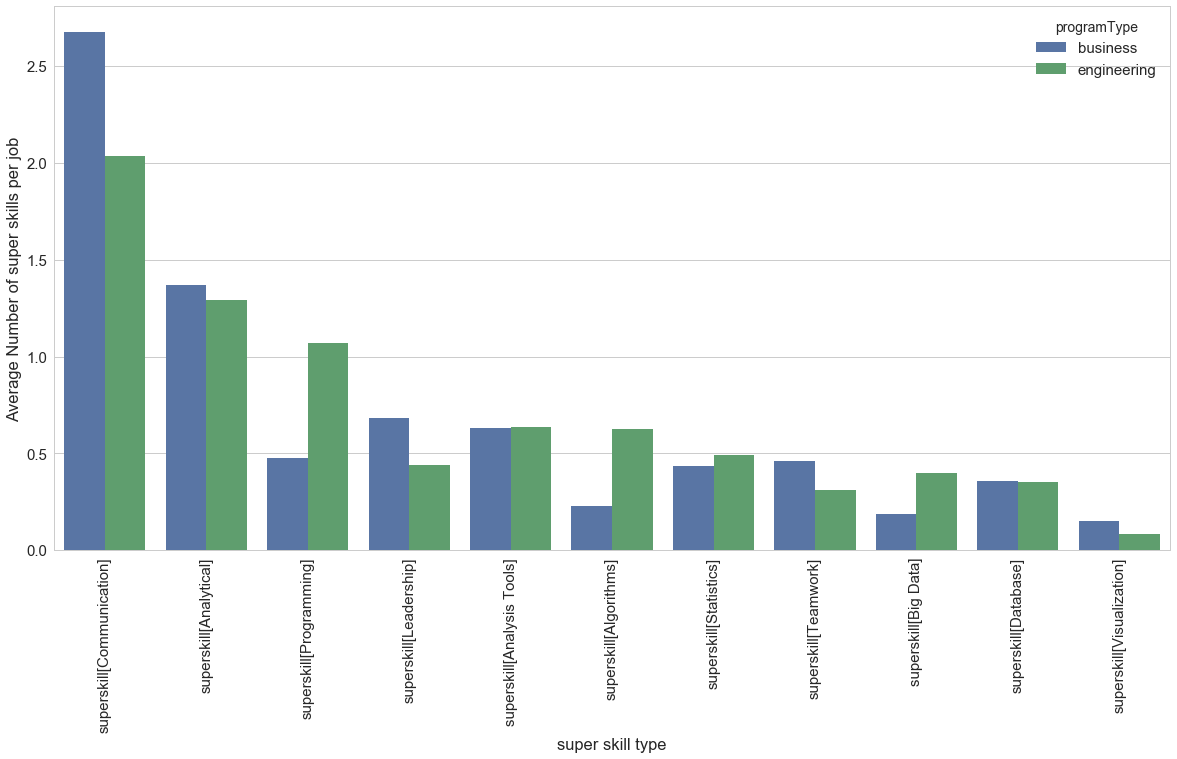

In [40]:
#plot freq
jdSS = jd.filter(regex=("^superskill.*"))
jdSS['programType'] = jd['programType']
data = jdSS.groupby('programType').mean()
a = data.reset_index().melt(id_vars=['programType'])
a = a.sort_values(by=['value', 'variable'], ascending=[False,False])
fig, axis1 = plt.subplots(1,1,figsize=(20,10))
ax = sns.barplot(x="variable", y="value", hue="programType", data=a) 
plt.xticks(rotation=90)
ax.set_ylabel("Average Number of super skills per job")
ax.set_xlabel("super skill type")

It is clear from the chart that business program requires more **soft skills** than **tech skills** which has been taken care while designing the masters' programs

Text(0.5,0,'skill type')

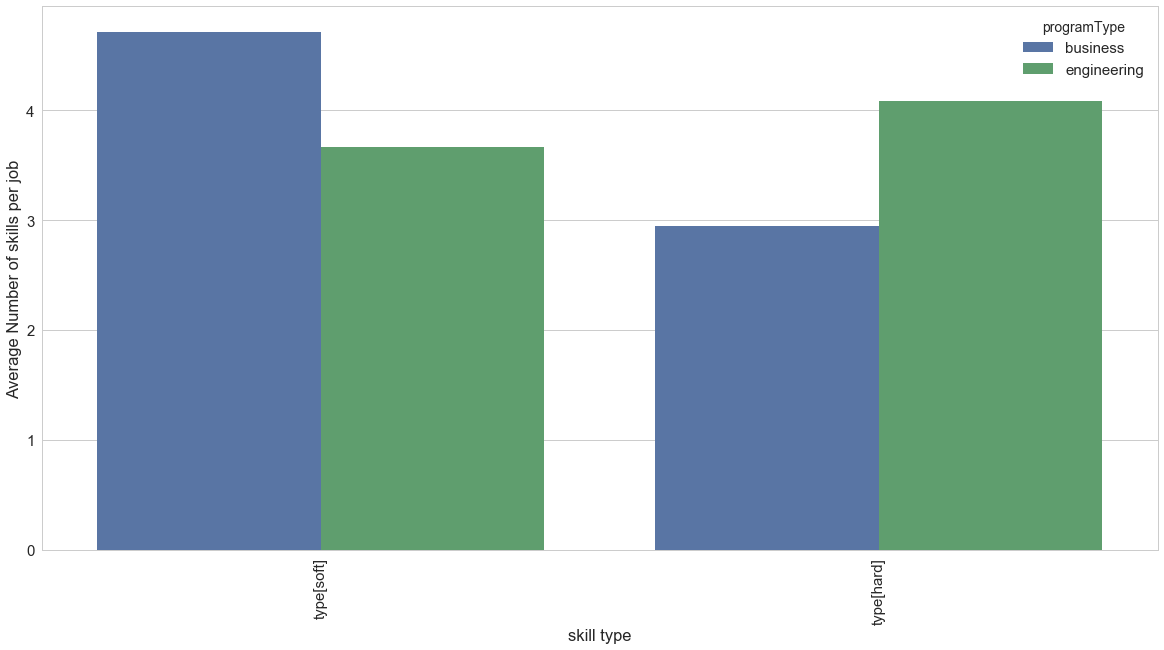

In [61]:
#plot freq
jdT = jd.filter(regex=("^type.*"))
jdT['programType'] = jd['programType']
data = jdT.groupby('programType').mean()
a = data.reset_index().melt(id_vars=['programType'])
a = a.sort_values(by=['value', 'variable'], ascending=[False,False])
fig, axis1 = plt.subplots(1,1,figsize=(20,10))
ax = sns.barplot(x="variable", y="value", hue="programType", data=a) 
plt.xticks(rotation=90)
ax.set_ylabel("Average Number of skills per job")
ax.set_xlabel("skill type")
